> Federated Learning Quantization Project for Harvard CS 2420: Computing at Scale (Fall 2024)


----
### **Quantization of Local Models for Reduced Communication Cost**
-----
Quantization refers to the process of reducing the number of bits used to represent a number. In the context of deep learning, the predominant numerical format used in research and deployment has been 32-bit floating-point ([IEEE 754 Format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format)).
However, the desire for reduced model size and computation has led to research on using fewer bits to represent numbers in deep learning models.
This can impact several aspects of the pipeline, including computation, communication, and storage requirements.
For example, in the context of federated learning, quantizing a client model from full (32-bit) precision to 8-bit precision will reduce the model size by ~4×.
Furthermore, because the model size is reduced, the communication required for uploading a client model is also reduced by ~4× as well.

However, this quantization comes with trade-offs.
To see this, consider a full precision representation (32-bit floating point). This representation has a large dynamic range (from $-3.4\times 10^{38}$ to $+3.4\times10^{38}$) and high precision (about $7$ decimal digits).
As a result, a full precision number can be seen as continuous data.
In contrast, $n$-bit fixed-point representations are limited to $2^n$ discrete values.
$n$-bit quantization generally refers to projecting a full precision weight to one of these $2^n$ discrete values by finding its nearest neighbor.  

In [1]:
import time
import copy
import sys
from collections import OrderedDict
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
def quantizer(input, nbit):
    '''
    input: full precision tensor in the range [0, 1]
    return: quantized tensor
    '''

    ## x = a/(2^n - 1) -> a ~ x * (2^n - 1)
    precision = (2 ** nbit) - 1
    return torch.round(precision * input) / precision

test_data = torch.tensor([i/11 for i in range(11)])

# ground truth results of 4-bit quantization
ground_truth = torch.tensor([0.0000, 0.0667, 0.2000, 0.2667, 0.3333, 0.4667,
                             0.5333, 0.6667, 0.7333, 0.8000, 0.9333])

quantizer_output = quantizer(test_data, 4)

if torch.allclose(quantizer_output, ground_truth, atol=1e-04):
    print('Output of Quantization Matches!')
else:
    print('Output of Quantization DOES NOT Match!')

Output of Quantization Matches!


**Quantize Weights of Neural Networks**

The quantizer will quantize any full-precision number in the range of $[0, 1]$ into an $n$-bit fixed-point number.
However, a weight $w$ in a neural network is not necessarily in the range $[0, 1]$.

We will first use a scaling function to transform weights into the range of $[0 ,1]$:
$$\tilde{w} = \frac{w}{2 \cdot \max(|w|)} + \frac{1}{2}$$
where $2 \cdot \max(|w|)$ is the **adaptive scale**.

Then, we quantize the transformed weights:
$$\hat{w} = \text{quantizer}_{\text{n-bit}}(\tilde{w})$$
After quantization, a reverse scaling function can be applied on $\hat{w}$ to recover the original scale:

$$w_q = 2 \cdot \max(|w|) \cdot \left( \hat{w}-\frac{1}{2} \right)$$

Combining these three equations, the expression we will use to get the quantized weights $w_q$ is as follows:
$$w_q = 2 \cdot \max(|w|) \cdot \left[ \text{quantizer}_{\text{n-bit}} \left( \frac{w}{2\max(|w|)} + \frac{1}{2} \right) - \frac{1}{2} \right]$$

This equation is the **deterministic quantization function**.

Following the method proposed by [DoReFa-Net](https://arxiv.org/abs/1606.06160), we enable *stochastic quantization* by adding extra noise $N(n) = \frac{\sigma}{2^n-1}$ to the transformed weights $\tilde{w}$, where $\sigma \sim \text{Uniform}(-0.5, 0.5)$ and $n$ is the number of bits.
Generally, including such extra noise will coax the model into exploring more of the loss surface, helping the model escape local minima and improve model generalizability.  

The final **stochastic quantization function** we will use to quantize layers of local models is:

$$w_q = 2 \cdot \max(|w|) \cdot \left[ \text{quantizer}_{\text{n-bit}} \left( \frac{w}{2 \cdot \max(|w|)} + \frac{1}{2} + N(n) \right) - \frac{1}{2} \right]$$



In [3]:
def quantize_model(model, nbit):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.weight.data, m.adaptive_scale = dorefa_g(m.weight, nbit)
            if m.bias is not None:
                m.bias.data,_ = dorefa_g(m.bias, nbit, m.adaptive_scale)

def dorefa_g(w, nbit, adaptive_scale=None):
    '''
    w: a floating-point weight tensor to quantize
    nbit: the number of bits in the quantized representation
    adaptive_scale: the maximum scale value. if None, it is set to be the
                    absolute maximum value in w.
    '''
    if adaptive_scale is None:
        adaptive_scale = 2 * torch.max(torch.abs(w))

    ## Get noise using shifted uniform distribution on [0, 1), then scale accordingly
    noise = (torch.rand(w.shape, device=w.device) - 1/2) / ((2 ** nbit) - 1)

    ## Compute w_tilde accordingly
    w_tilde = w/adaptive_scale + 1/2 + noise

    ## Compute w_hat by applying quantizer
    w_hat = quantizer(w_tilde, nbit)

    ## Compute w_q
    w_q = adaptive_scale * (w_hat - 1/2)

    return w_q, adaptive_scale


test_data = torch.tensor([i/11 for i in range(11)])

# ground truth results of 4-bit quantization
ground_truth = torch.tensor([-0.0606, 0.0606, 0.1818, 0.3030, 0.3030, 0.4242,
                             0.5455, 0.5455, 0.7879, 0.7879, 0.9091])

torch.manual_seed(43)
quantizer_output, adaptive_scale = dorefa_g(test_data, 4)

print(ground_truth)
print(quantizer_output)
if torch.allclose(quantizer_output, ground_truth, atol=1e-04):
    print('Output of Quantization Matches!')
else:
    print('Output of Quantization DOES NOT Match!')

tensor([-0.0606,  0.0606,  0.1818,  0.3030,  0.3030,  0.4242,  0.5455,  0.5455,
         0.7879,  0.7879,  0.9091])
tensor([-0.0606,  0.0606,  0.1818,  0.3030,  0.3030,  0.4242,  0.5455,  0.5455,
         0.7879,  0.7879,  0.9091])
Output of Quantization Matches!


**Reduce the Communication Overhead with Quantization**

We will now explore the performance impact of quantization on federated learning:

In [4]:
# federated learning helped functions
def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentage of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''

    # total number of samples in the dataset
    total_samples = len(dataset)

    num_samples_per_device = int(data_pct * total_samples + 0.5)

    sampled = {}
    for device_id in range(num_devices):
        sampled_indices = np.random.choice(
            total_samples, num_samples_per_device, replace=True
        )
        sampled[device_id] = sampled_indices.tolist()

    return sampled


def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }


def average_weights(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''

    num_devices = len(devices)
    if num_devices == 0:
        return None

    avg_weights = OrderedDict()

    for i, device in enumerate(devices):
        state_dict = device['net'].state_dict()
        if i == 0:
            for key in state_dict.keys():
                avg_weights[key] = state_dict[key].clone()
        else:
            for key in state_dict.keys():
                avg_weights[key] += state_dict[key]

    for key in avg_weights.keys():
        avg_weights[key] = avg_weights[key] / num_devices

    return avg_weights


def get_devices_for_round(devices, device_pct):
    '''
    '''
    num_devices = len(devices)
    num_selected = max(1, int(device_pct * num_devices))
    selected_devices = random.sample(devices, num_selected)
    return selected_devices

In [5]:
# Using CIFAR-10
# Load training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)


def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

100%|██████████| 170M/170M [00:06<00:00, 26.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
import copy

class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }

def train(epoch, device):
    net.train()
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.cuda(), targets.cuda()
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' +
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device):
    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)

In [ ]:
# Parameters
rounds = 30
local_epochs = 4
num_devices = 50
device_pct = 0.1
data_pct = 0.1
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()

# Bit-width values to test
bit_widths = [4, 16, 32]
accuracy_data = {nbit: [] for nbit in bit_widths}  # Dictionary to store accuracy for each bit-width

# Dataset and device initialization
data_idxs = iid_sampler(trainset, num_devices, data_pct)
devices_template = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)]

# Loop over each bit-width
for nbit in bit_widths:
    print(f"Evaluating quantization with nbit={nbit}")
    devices = [copy.deepcopy(device) for device in devices_template]  # Deep copy for independent runs
    start_time = time.time()

    for round_num in range(rounds):
        ## Local training
        round_devices = get_devices_for_round(devices, device_pct)
        print('Round: ', round_num)

        for device in round_devices:
            for local_epoch in range(local_epochs):
                train(local_epoch, device)

        ## Quantize all tensors in each device with the current nbit
        for device in round_devices:
            curr_state_dict = device['net'].state_dict()
            for key, value in curr_state_dict.items():
                curr_state_dict[key] = dorefa_g(value, nbit)[0]
            device['net'].load_state_dict(curr_state_dict)

        # Average weights across devices and distribute to all devices
        w_avg = average_weights(round_devices)
        for device in devices:
            device['net'].load_state_dict(w_avg)
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            device['scheduler'].step()

        # Test accuracy after aggregation and store it for plotting
        test(round_num, devices[0])  # Accuracy tracked in devices[0]['test_acc_tracker']
        accuracy = devices[0]['test_acc_tracker'][-1]  # Get latest test accuracy
        accuracy_data[nbit].append(accuracy)

    total_time = time.time() - start_time
    print(f'Total training time for nbit={nbit}: {total_time:.2f} seconds')

Results (graph generated on separate notebook instance):

The $16$-bit width quantized model seems to have performed better than the full-precision model. This is likely due to factors in randomness and such; there is nothing significant enough to suggest $16$-bit width is "better". The different models are quite close in accuracy though, with final accuracies being within a 3\% accuracy range. This suggests that $4$-bit quantization is still quite reliable for this task.

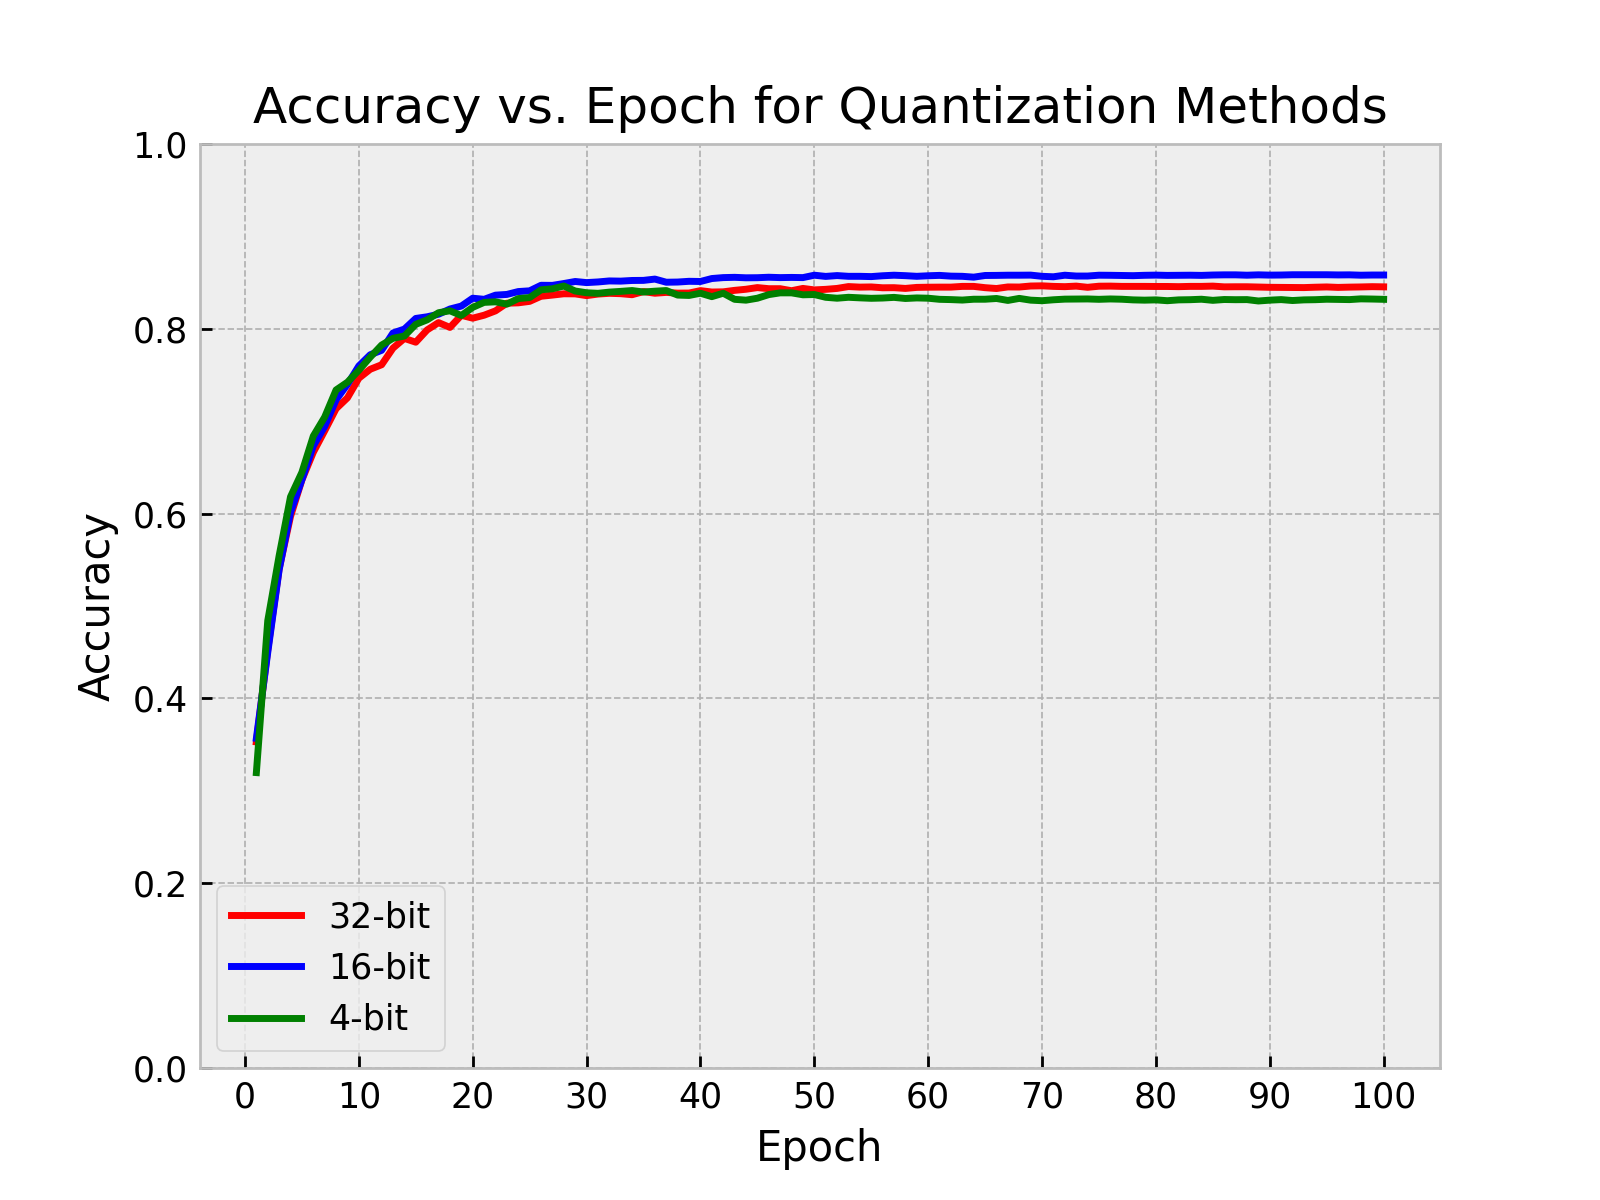